# Image Classification and Object Localization

In this Code:
- classify the main subject in an image
- localize it by drawing bounding boxes around it.

Dataset:
- [MNIST](http://yann.lecun.com/exdb/mnist/):
- Place each "digit" image on a black canvas of width 75 x 75 at random locations.
- Calculate the corresponding bounding boxes for those "digits".

The bounding box prediction can be modelled as a "regression" task, which means that the model will predict a numeric value (as opposed to a category).

In [1]:
import os, re, time, json
from PIL import Image, ImageDraw, ImageFont
import numpy as np

import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")


Python Platform: macOS-12.4-arm64-arm-64bit
Tensor Flow Version: 2.10.0
Numpy Version: 1.23.2
Keras Version: 2.10.0
GPU is available


## Detecting the devices for distributed strategy

In [2]:
# Detect hardware
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices('GPU')

Metal device set to: Apple M2


2022-10-05 17:09:25.522074: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-05 17:09:25.522846: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU', tpu.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print('Running on multi GPUs', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy()
    print('Running on single GPU', gpus[0].name)
else:
    strategy = tf.distribute.get_strategy()
    print('Running on CPU')
    
print('Number of accelerators', strategy.num_replicas_in_sync)

Running on single GPU /device:GPU:0
Number of accelerators 1


In [4]:
BATCH_SIZE = 64 * strategy.num_replicas_in_sync # Global batch size

In [5]:
def read_image_tfds(image, label):
    '''
    Transforms each image in dataset by pasting it on a 75x75 canvas at random locations.
    Args:
        image: original image in dataset, 28x28
        label: label
        
    '''
    xmin = tf.random.uniform((), 0 , 48, dtype=tf.int32)
    ymin = tf.random.uniform((), 0 , 48, dtype=tf.int32)
    image = tf.reshape(image, (28,28,1,))
    image = tf.image.pad_to_bounding_box(image, ymin, xmin, 75, 75)
    image = tf.cast(image, tf.float32)/255.0
    xmin = tf.cast(xmin, tf.float32)
    ymin = tf.cast(ymin, tf.float32)
   
    xmax = (xmin + 28) / 75
    ymax = (ymin + 28) / 75
    xmin = xmin / 75
    ymin = ymin / 75
    return image, (tf.one_hot(label, 10), [xmin, ymin, xmax, ymax])

def get_dataset():
    '''
    Loads and maps the training split of the dataset using the map function. 
    Note that we need to load the gcs version if using TPU in Google colab.

    '''
    with strategy.scope():
        splits, info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, 
                                 with_info=True, data_dir='./mnist', download=False)
        train_data, test_data = splits
        train_batches = train_data.map(read_image_tfds, num_parallel_calls = 16)
        train_batches = train_batches.shuffle(5000, reshuffle_each_iteration=True)
        train_batches = train_batches.repeat().batch(BATCH_SIZE, drop_remainder=True).prefetch(-1)
        
        test_batches = test_data.map(read_image_tfds, num_parallel_calls=16)
        test_batches = test_batches.batch(10000, drop_remainder=True)
        test_batches = test_batches.repeat()
    
    return train_batches, test_batches, info

In [139]:
image_pil = Image.fromarray(x[0])

In [141]:
rgbimg = Image.new("RGBA", image_pil.size)

In [144]:
rgbimg.paste(image_pil)

In [148]:
draw = ImageDraw.Draw(rgbimg)

In [157]:
im_width, im_height = rgbimg.size
xmin, ymin, xmax, ymax = [0.        , 0.14666666, 0.37333333, 0.52      ]
if use_normalized_coordinates:
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                              ymin * im_height, ymax * im_height)
else:
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
draw.line([(left, top), (left, bottom), (right, bottom),
         (right, top), (left, top)], width=1, fill='red')

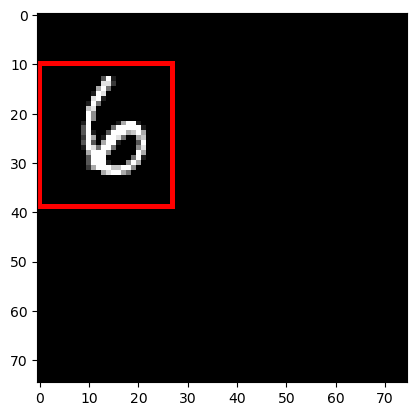

In [158]:
plt.imshow(rgbimg)

In [6]:
im_width = 75
im_height = 75
use_normalized_coordinates = True

def draw_bounding_boxes_on_image_array(image,
                                       boxes,
                                       color=[],
                                       thickness=1,
                                       display_str_list=()):
    """Draws bounding boxes on image (numpy array).
    Args:
      image: a numpy array object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
      display_str_list_list: a list of strings for each bounding box.
    Raises:
      ValueError: if boxes is not a [N, 4] array
    """
#     print('image', image.shape)
    image_pil = Image.fromarray(image)
    rgbimg = Image.new("RGBA", image_pil.size)
    rgbimg.paste(image_pil)
    draw_bounding_boxes_on_image(rgbimg, boxes, color, thickness,
                                 display_str_list)
    return np.array(rgbimg)


def draw_bounding_boxes_on_image(image,
                                 boxes,
                                 color=[],
                                 thickness=1,
                                 display_str_list=()):
    
    """Draws bounding boxes on image.
      Args:
        image: a PIL.Image object.
        boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
               The coordinates are in normalized format between [0, 1].
        color: color to draw bounding box. Default is red.
        thickness: line thickness. Default value is 4.
        display_str_list: a list of strings for each bounding box.

      Raises:
        ValueError: if boxes is not a [N, 4] array
    """
    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N, 4]')
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                               boxes[i, 2], color[i], thickness, display_str_list[i])
        
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color='red',
                               thickness=1,
                               display_str=None,
                               use_normalized_coordinates=True):
    """Adds a bounding box to an image.
      Bounding box coordinates can be specified in either absolute (pixel) or
      normalized coordinates by setting the use_normalized_coordinates argument.
      Args:
        image: a PIL.Image object.
        ymin: ymin of bounding box.
        xmin: xmin of bounding box.
        ymax: ymax of bounding box.
        xmax: xmax of bounding box.
        color: color to draw bounding box. Default is red.
        thickness: line thickness. Default value is 4.
        display_str_list: string to display in box
        use_normalized_coordinates: If True (default), treat coordinates
          ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
          coordinates as absolute.
    """
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    if use_normalized_coordinates:
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    else:
        (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
    draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)


def display_digits_with_boxes(digits, predictions, labels, pred_bboxes, bboxes, iou, title):

    n = 10
    indexes = np.random.choice(len(predictions), size=n)

    n_digits = digits[indexes]
    n_predictions = predictions[indexes]
    n_labels = labels[indexes]

    n_iou = []
    if len(iou) > 0:
        n_iou = iou[indexes]

    if (len(pred_bboxes) > 0):
        n_pred_bboxes = pred_bboxes[indexes,:]

    if (len(bboxes) > 0):
        n_bboxes = bboxes[indexes,:]


    n_digits = n_digits * 255.0
#     print(digits.shape, n_digits.shape)
    
    n_digits = n_digits.reshape(n, 75, 75)
    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
  
    for i in range(10):
        ax = fig.add_subplot(1, 10, i+1)
        bboxes_to_plot = []
        if (len(pred_bboxes) > i):
            bboxes_to_plot.append(n_pred_bboxes[i])
    
        if (len(bboxes) > i):
            bboxes_to_plot.append(n_bboxes[i])

        img_to_draw = draw_bounding_boxes_on_image_array(image=n_digits[i], boxes=np.asarray(bboxes_to_plot), 
                                                         color=['red', 'green'], display_str_list=["true", "pred"])
        plt.xlabel(n_predictions[i])
        plt.xticks([])
        plt.yticks([])
    
        if n_predictions[i] != n_labels[i]:
            ax.xaxis.label.set_color('red')

        plt.imshow(img_to_draw)

        if len(iou) > i :
            color = "black"
            if (n_iou[i][0] < iou_threshold):
                color = "red"
            ax.text(0.2, -0.3, "iou: %s" %(n_iou[i][0]), color=color, transform=ax.transAxes)

In [7]:
# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

def dataset_to_numpy_util(training_dataset, validation_dataset, N):

    """
    This cell contains helper functions used for visualization
    and downloads only. 

    You can skip reading it, as there is very
    little Keras or Tensorflow related code here.
    """

  # get one batch from each: 10000 validation digits, N training digits
    batch_train_ds = training_dataset.unbatch().batch(N)
  
  # eager execution: loop through datasets normally
    if tf.executing_eagerly():
        for validation_digits, (validation_labels, validation_bboxes) in validation_dataset:
            validation_digits = validation_digits.numpy()
            validation_labels = validation_labels.numpy()
            validation_bboxes = validation_bboxes.numpy()
            break
            
        for training_digits, (training_labels, training_bboxes) in batch_train_ds:
            training_digits = training_digits.numpy()
            training_labels = training_labels.numpy()
            training_bboxes = training_bboxes.numpy()
            break 
  
  # these were one-hot encoded in the dataset
    validation_labels = np.argmax(validation_labels, axis=1)
    training_labels = np.argmax(training_labels, axis=1)
  
    return (training_digits, training_labels, training_bboxes,
            validation_digits, validation_labels, validation_bboxes)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
    font_labels = []
    img = Image.new('LA', (75*n, 75), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
    font1 = ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
    font2 = ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
    d = ImageDraw.Draw(img)
    for i in range(n):
        font_labels.append(i%10)
        d.text((7+i*75,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
    font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
    font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [75, 75*n]), n, axis=1), axis=0), [n, 75*75])
    return font_digits, font_labels


In [8]:
with strategy.scope():
    train_batches, test_batches, info = get_dataset()

In [9]:
info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='./mnist/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [10]:
(training_digits, training_labels, training_bboxes,
 validation_digits, validation_labels, validation_bboxes) = dataset_to_numpy_util(train_batches, test_batches, 10)

2022-10-05 17:10:16.682601: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-05 17:10:17.046666: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


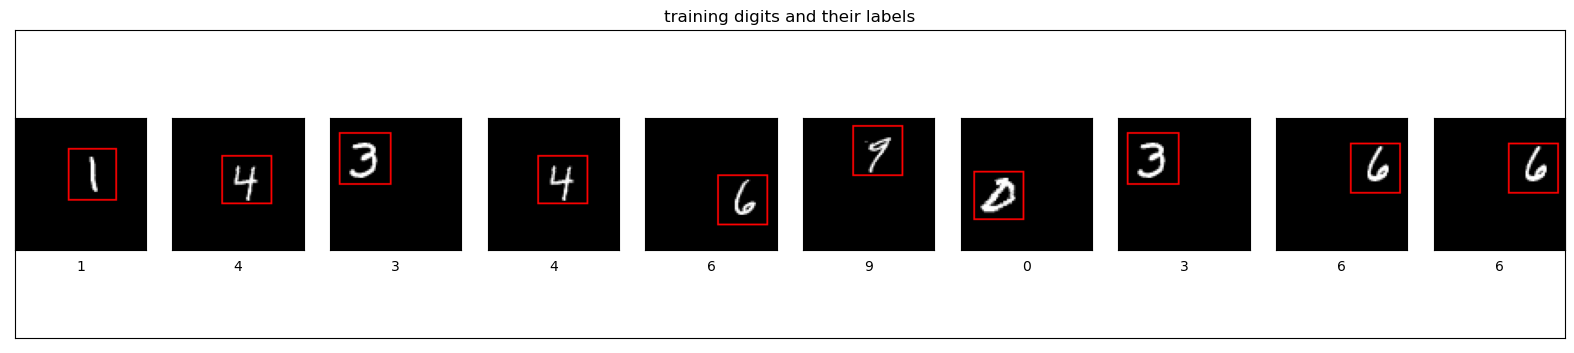

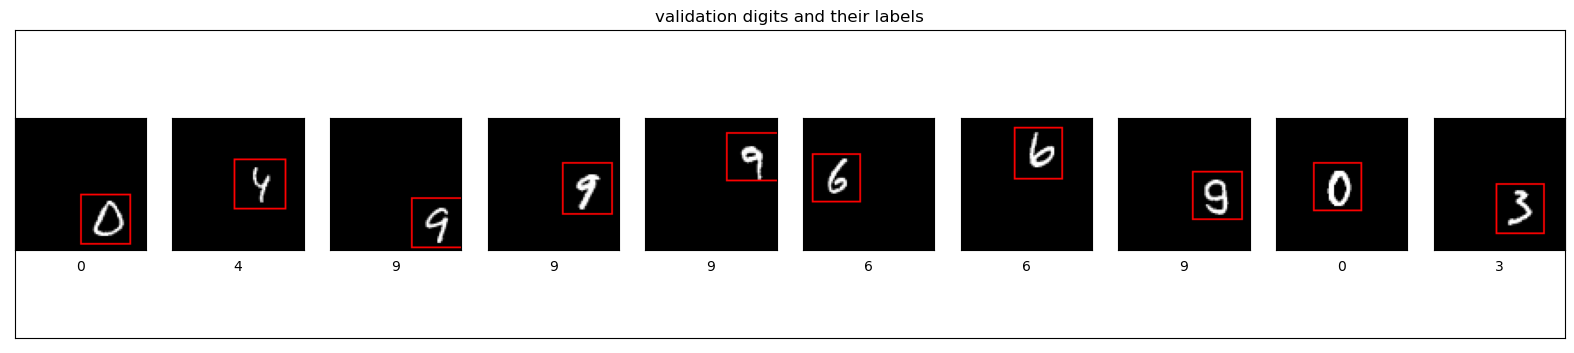

In [11]:
display_digits_with_boxes(training_digits, training_labels, training_labels, np.array([]), training_bboxes, np.array([]), "training digits and their labels")
display_digits_with_boxes(validation_digits, validation_labels, validation_labels, np.array([]), validation_bboxes, np.array([]), "validation digits and their labels")

In [12]:
def feature_extractor(inputs):
    x = tf.keras.layers.Conv2D(16, activation='relu', kernel_size=3, input_shape=(75, 75, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(32, activation='relu', kernel_size=3)(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, activation='relu', kernel_size=3)(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    
    return x

def dense_layers(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(128, 'relu')(x)
    
    return x

def classifier(inputs):
    
    classifier_output = tf.keras.layers.Dense(10, activation='softmax', name='classifier')(inputs)
    return classifier_output

def bounding_box_regression(inputs):
    
    bounding_box_regression_output = tf.keras.layers.Dense(4, name = 'bounding_box')(inputs)
    return bounding_box_regression_output

def final_model(inputs):
    feature_cnn = feature_extractor(inputs)
    dense_output = dense_layers(feature_cnn)
    
    classifier_output = classifier(dense_output)
    bounding_box_regression_output = bounding_box_regression(dense_output)
    
    model = tf.keras.Model(inputs=inputs, outputs=[classifier_output, bounding_box_regression_output])
    
    return model

def define_and_compile_model(inputs):
    model = final_model(inputs)
    
    model.compile(optimizer='adam',
                  loss = {'classifier': 'categorical_crossentropy',
                        'bounding_box': 'mse'
                         },
                  metrics = {'classifier' : 'accuracy',
                         'bounding_box' : 'mse'
                        }
                 )    
    return model
    
    

In [13]:
with strategy.scope():
    inputs = tf.keras.layers.Input(shape=(75, 75, 1))
    model = define_and_compile_model(inputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 73, 73, 16)   160         ['input_1[0][0]']                
                                                                                                  
 average_pooling2d (AveragePool  (None, 36, 36, 16)  0           ['conv2d[0][0]']                 
 ing2D)                                                                                           
                                                                                                  
 conv2d_1 (Conv2D)              (None, 34, 34, 32)   4640        ['average_pooling2d[0][0]']  

In [14]:
EPOCHS = 10
steps_per_epoch = 60000//BATCH_SIZE
validation_steps = 1

history = model.fit(train_batches, epochs=EPOCHS, validation_data=test_batches,
                    steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)
loss, classification_loss, bounding_box_loss, classification_accuracy, bounding_box_mse = model.evaluate(test_batches, steps=1)



Epoch 1/10


2022-10-05 17:10:28.437924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


936/937 [============================>.] - ETA: 0s - loss: 0.9155 - classifier_loss: 0.8992 - bounding_box_loss: 0.0163 - classifier_accuracy: 0.6878 - bounding_box_mse: 0.0163

2022-10-05 17:10:41.372991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


937/937 [==============================] - 16s 16ms/step - loss: 0.9149 - classifier_loss: 0.8986 - bounding_box_loss: 0.0163 - classifier_accuracy: 0.6880 - bounding_box_mse: 0.0163 - val_loss: 9.9822 - val_classifier_loss: 9.8938 - val_bounding_box_loss: 0.0884 - val_classifier_accuracy: 0.2330 - val_bounding_box_mse: 0.0884
Epoch 2/10
937/937 [==============================] - 14s 15ms/step - loss: 0.2802 - classifier_loss: 0.2736 - bounding_box_loss: 0.0067 - classifier_accuracy: 0.9163 - bounding_box_mse: 0.0067 - val_loss: 12.3164 - val_classifier_loss: 12.2223 - val_bounding_box_loss: 0.0941 - val_classifier_accuracy: 0.2073 - val_bounding_box_mse: 0.0941
Epoch 3/10
937/937 [==============================] - 14s 15ms/step - loss: 0.1962 - classifier_loss: 0.1923 - bounding_box_loss: 0.0039 - classifier_accuracy: 0.9407 - bounding_box_mse: 0.0039 - val_loss: 15.8472 - val_classifier_loss: 15.7674 - val_bounding_box_loss: 0.0798 - val_classifier_accuracy: 0.1880 - val_bounding_box

## Define the Network

<img src='./CNN.jpeg'>

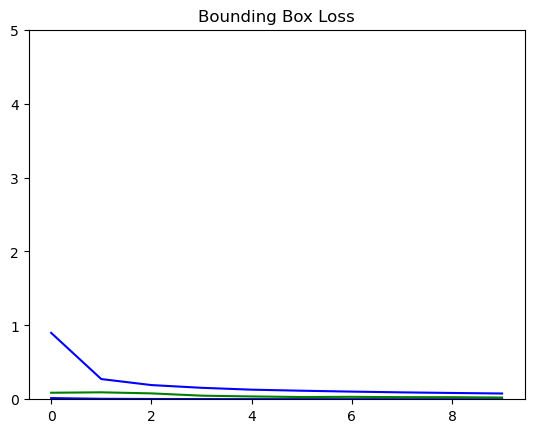

In [17]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)
    
plot_metrics("classifier_loss", "Classification Loss")
plot_metrics("bounding_box_loss", "Bounding Box Loss")

## Intersection over union

Calculate the I-O-U metric to evaluate the model's performance.

In [18]:
def intersection_over_union(pred_box, true_box):
    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    smoothing_factor = 1e-10

    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    overlap_area = np.maximum((xmax_overlap - xmin_overlap), 0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area
    
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

 17/157 [==>...........................] - ETA: 0s

2022-10-05 17:16:18.576794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - 1s 4ms/step
Number of predictions where iou > threshold(0.6): 9474
Number of predictions where iou < threshold(0.6): 526


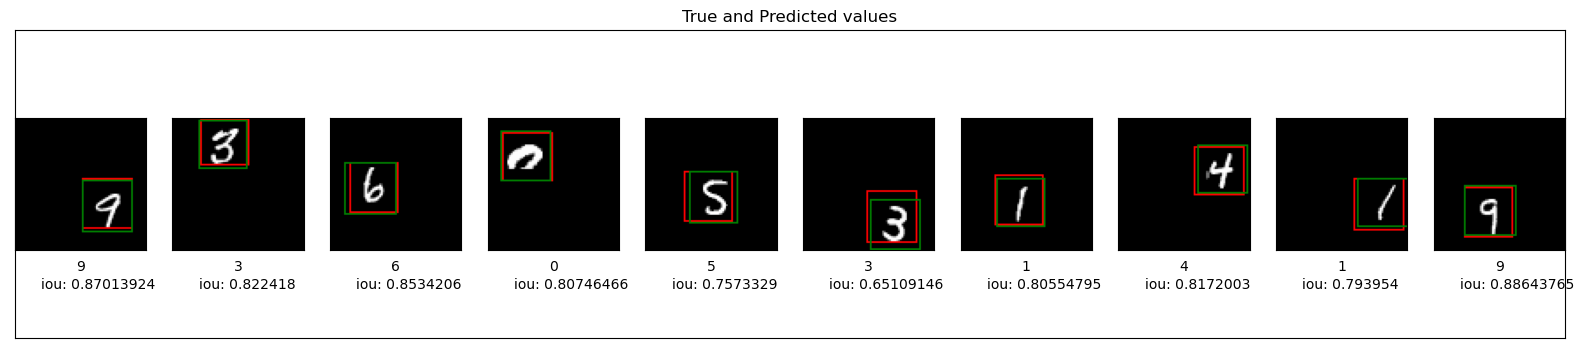

In [19]:
predictions = model.predict(validation_digits, batch_size=64)
predicted_labels = np.argmax(predictions[0], axis=1)

predicted_bboxes = predictions[1]

iou = intersection_over_union(predicted_bboxes, validation_bboxes)

iou_threshold = 0.6

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))


display_digits_with_boxes(validation_digits, predicted_labels, validation_labels, predicted_bboxes, validation_bboxes, iou, "True and Predicted values")